In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras import layers,models
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import random
import scipy
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
train_df = pd.read_csv('//kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")

    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    
    axs[1, i].axis("off")
    
plt.show()
# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [ ]:
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

In [ ]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

In [ ]:
def resize_images(images,img_size):
    list_images = list()
    for img in images:
        normal_image = tf.cast(img, tf.float32) / 255.0
        img_resized = resize(normal_image,img_size, anti_aliasing=True)
        list_images.append(img_resized)
    return np.array(list_images) 

def resize_masks(masks,mask_size):
    list_masks = list()
    for mask in masks:
        mask_resized = tf.image.resize(mask[None,...,None],mask_size, method  =tf.image.ResizeMethod.NEAREST_NEIGHBOR )
        mask_resized = np.clip(mask_resized,0,len(labels))
        list_masks.append(mask_resized[0,:,:,0])
    return np.array(list_masks) 

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if (i > 0):
      plt.imshow(display_list[i], vmin=0,vmax=len(labels))
    else:
      plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [ ]:

IMG_WIDTH = 224
IMG_HEIGHT = 224
NUM_LABELS = len(labels) + 1

X_train = resize_images(train_df["img"],(IMG_HEIGHT,IMG_WIDTH,3))
Y_train = resize_masks(train_df["seg"],(IMG_HEIGHT,IMG_WIDTH))

X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.2,random_state=42)

In [ ]:
def augment(X, Y):
  flip = np.random.random(X.shape[0])
#   rotate = np.random.random(X.shape[0])
  rotate = np.zeros(X.shape[0])
  X_new = np.empty((X.shape[0] + np.sum(flip > 0.5)+ np.sum(rotate > 0.5), X.shape[1],X.shape[2],X.shape[3]), dtype=X.dtype)
  Y_new = np.empty((Y.shape[0] + np.sum(flip > 0.5)+ np.sum(rotate > 0.5), Y.shape[1],Y.shape[2]),dtype=Y.dtype)
  ind = 0
  for i in range(X.shape[0]):
    X_new[ind] = X[i]
    Y_new[ind] = Y[i]
    ind += 1
    if flip[i]>0.5:
      X_new[ind] = np.fliplr(X[i])
      Y_new[ind] = np.fliplr(Y[i])
      ind += 1
    if rotate[i]>0.5:
      rot = random.random()*36-18
      X_new[ind] = scipy.ndimage.rotate(X[i],rot,mode = "reflect",reshape=False)
      Y_new[ind] = scipy.ndimage.rotate(Y[i],rot,mode = "reflect",reshape=False)
      ind += 1
  
  return X_new, Y_new
  
X_aug, Y_aug = augment(X_train,Y_train)
np.unique(Y_aug)

TRAIN_LENGTH = X_train.shape[0]
BATCH_SIZE = 32
BUFFER_SIZE = 1500
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

training_set = tf.data.Dataset.from_tensor_slices((X_aug, Y_aug))
val_set = tf.data.Dataset.from_tensor_slices((X_val,Y_val))
train_batches = (
    training_set
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_set.batch(BATCH_SIZE)
for images, masks in train_batches.take(4):
    sample_image, sample_mask = images[0], masks[0]
    display((sample_image,sample_mask))

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = X_val.shape[0]//BATCH_SIZE//VAL_SUBSPLITS

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image[None,:].shape)
      print(model.predict(image[None, :]).shape)
      pred_mask = np.argmax(model.predict(image[None, :]),axis=-1).astype(np.uint8)[0]
      print(pred_mask.shape)
      display((image, mask,pred_mask))
  else:
    display([sample_image, sample_mask,
             np.argmax(model.predict(sample_image[None, :]),axis=-1).astype(np.uint8)[0]])


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
def create_model(img_size, num_classes):
    inputs = tf.keras.layers.Input(img_size)
    #Contraction path
    x = inputs
    cs = []
    filter_sizes = [64,128,256]
    for i in range(len(filter_sizes)):
        c1 = tf.keras.layers.Conv2D(filter_sizes[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1 = tf.keras.layers.Conv2D(filter_sizes[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
        cs.append(c1)
        x = tf.keras.layers.BatchNormalization()(c1)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    c5 = tf.keras.layers.Dropout(0.3)(x)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    x = c5

    #Expansive path 
    for j in range(len(filter_sizes)):
        i = len(filter_sizes)-j-1
        x = tf.keras.layers.Conv2DTranspose(filter_sizes[i], (2, 2), strides=(2, 2), padding='same')(x)
        x = tf.keras.layers.concatenate([x, cs[i]])
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)

    
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation='softmax', padding="same")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def create_model(img_size, num_classes):
    inputs = tf.keras.layers.Input(img_size)
    #Contraction path
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    previous_block_activation = x  # Set aside residual
    cs = []
    filter_sizes = [64,128,256]
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    #Expansive path 
    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation='softmax', padding="same")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = create_model((IMG_HEIGHT,IMG_WIDTH,3), NUM_LABELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(val_set, 3)

In [16]:
distribution = np.mean([[np.sum(Y_ == i) / Y_.size for i in range(len(labels) + 1)] for Y_ in Y_train], axis=0)
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant(1/distribution)
  temp = 20
  class_weights = np.array([1,temp, temp,temp, temp,temp, temp,temp, temp,temp, temp,temp, temp,temp, temp,temp, temp,temp, temp,temp, temp])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
model_history = model.fit(train_batches.map(add_sample_weights), epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(training_set, 5)

# Transfer learning

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3],weights='imagenet', include_top=False)
layer_names = [
    'block_1_expand_relu', 
    'block_3_expand_relu',  
    'block_6_expand_relu', 
    'block_13_expand_relu', 
    'block_16_project',      
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)


down_stack.trainable = False

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
OUTPUT_CLASSES = len(labels)+1

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ [(None, 112, 112, │  1,841,984 │ input_layer_2[0]… │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 14, 14,    │  1,476,608 │ functional_3[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 14, 14,    │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 28, 28,    │  2,507,776 │ concatenate_3[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 28, 28,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 56, 56,    │    516,608 │ concatenate_4[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 56, 56,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 112, 112,  │    156,928 │ concatenate_5[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 112, 112,  │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 224, 224,  │     30,261 │ concatenate_6[0]… │
│ (Conv2DTranspose)   │ 21)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,530,165 (24.91 MB)

 Trainable params: 4,686,261 (17.88 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


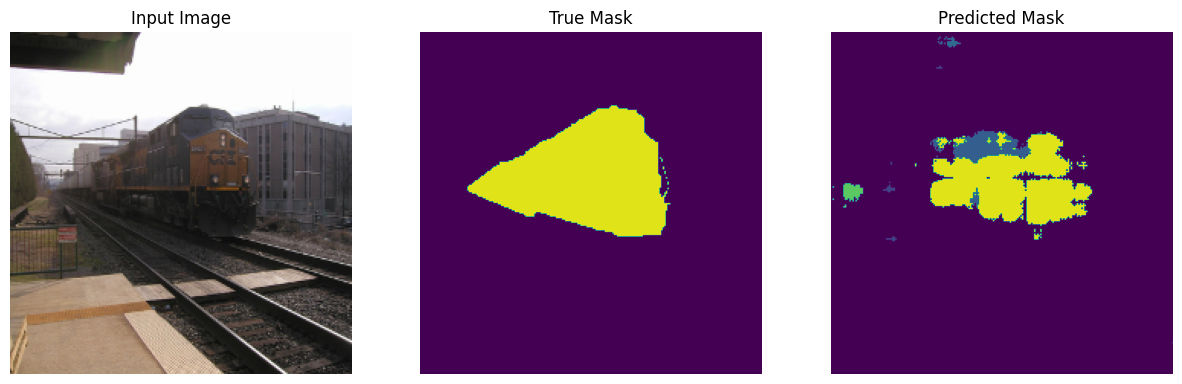


Sample Prediction after epoch 30

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.8593 - loss: 0.0046 - val_accuracy: 0.8467 - val_loss: 0.5571


In [18]:
model_history = model.fit(train_batches.map(add_sample_weights), epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


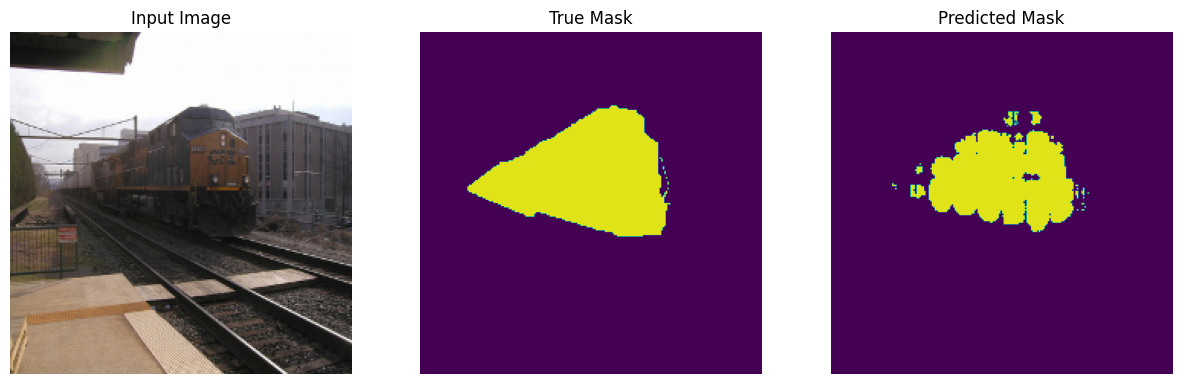


Sample Prediction after epoch 30

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9556 - loss: 0.1256 - val_accuracy: 0.8644 - val_loss: 0.5706


In [19]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

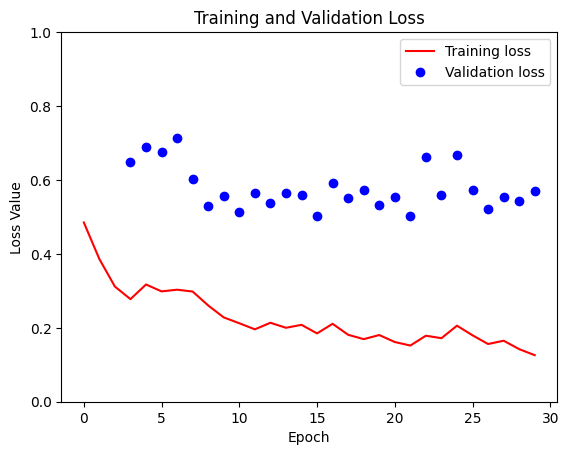

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

finetuning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


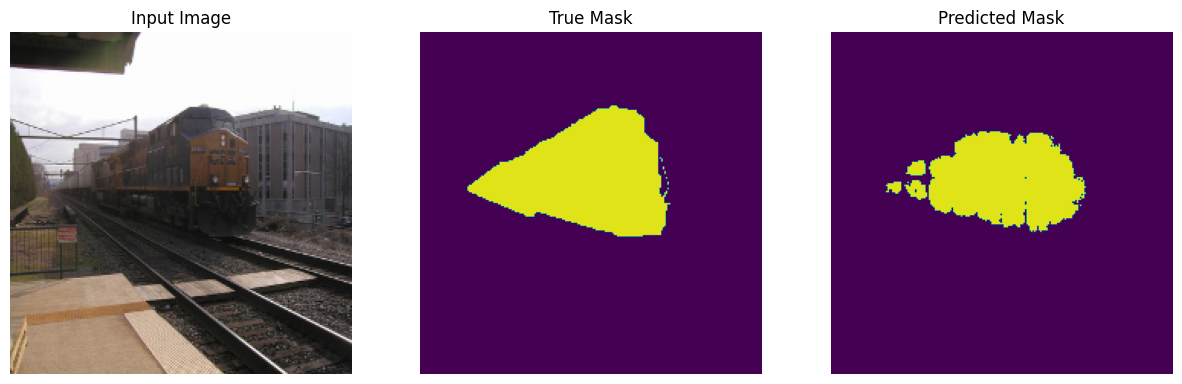


Sample Prediction after epoch 20

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9464 - loss: 0.1608 - val_accuracy: 0.8710 - val_loss: 0.5500


In [22]:
down_stack.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_history = model.fit(train_batches, epochs=20,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

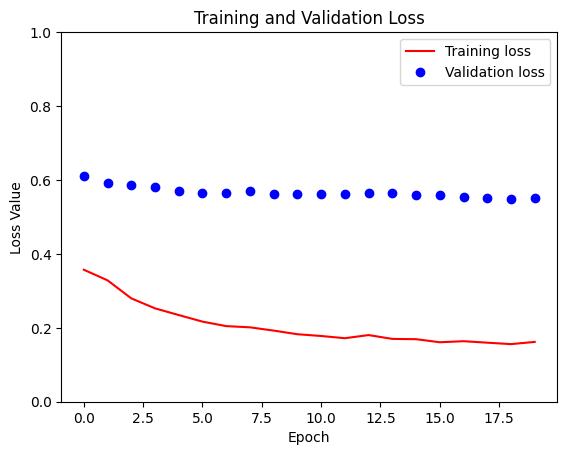

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(1, 224, 224, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(224, 224)


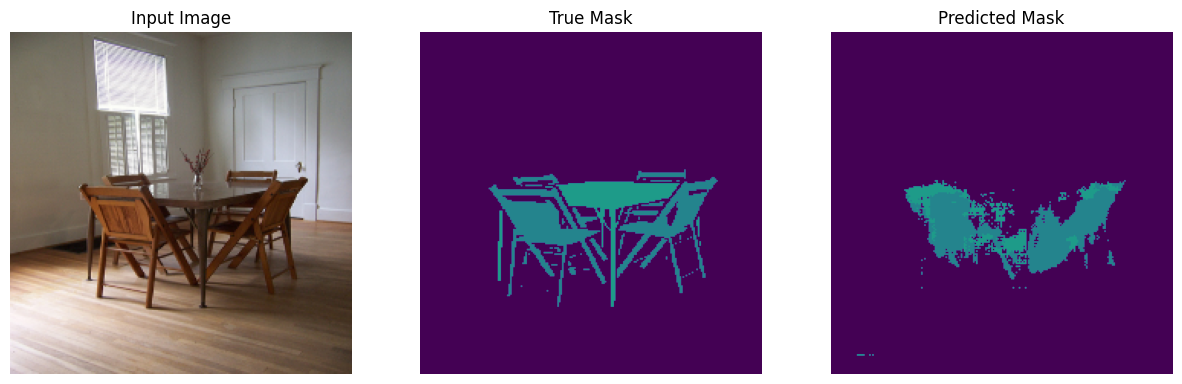

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(1, 224, 224, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(224, 224)


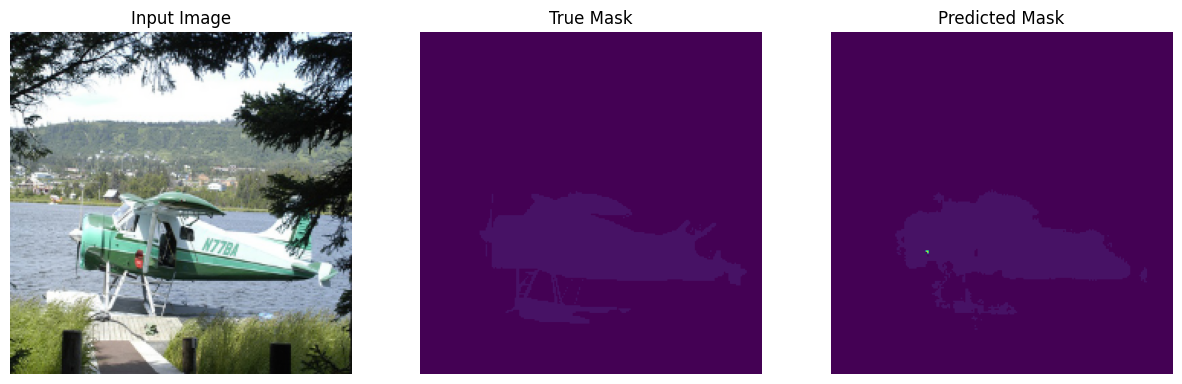

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(1, 224, 224, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(224, 224)


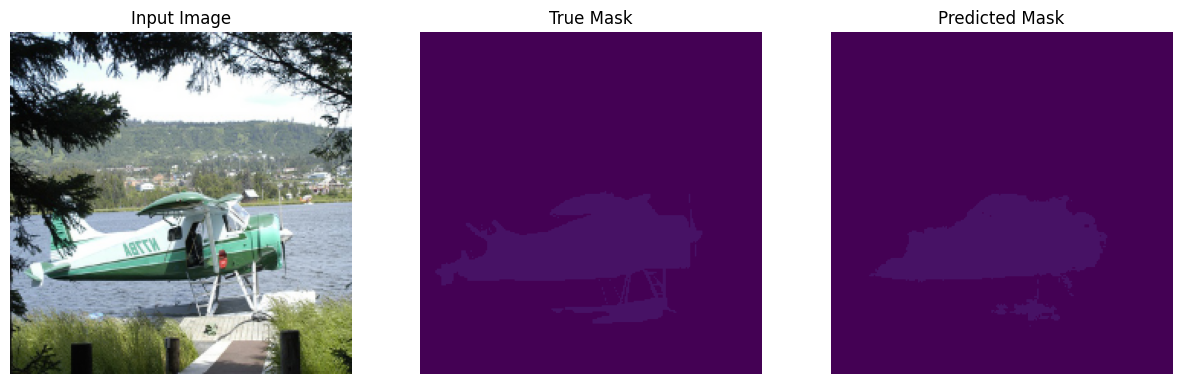

In [24]:
show_predictions(training_set, 3)

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(1, 224, 224, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(224, 224)


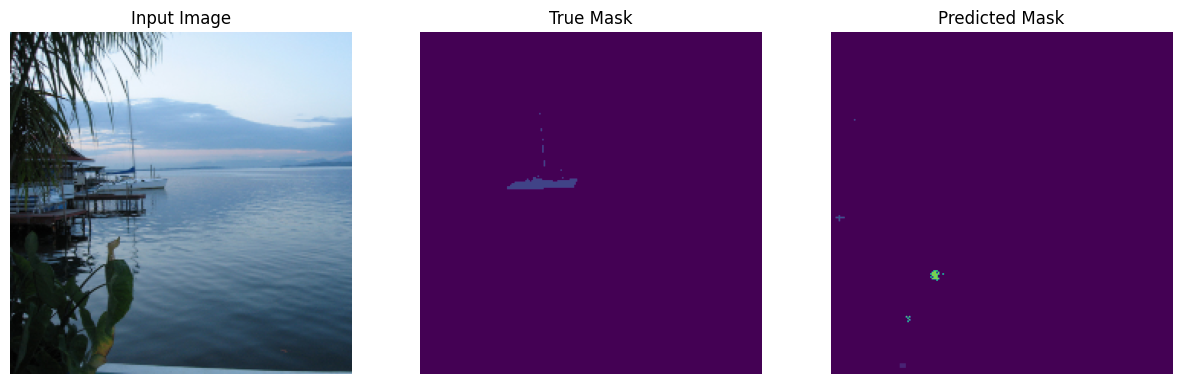

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(1, 224, 224, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(224, 224)


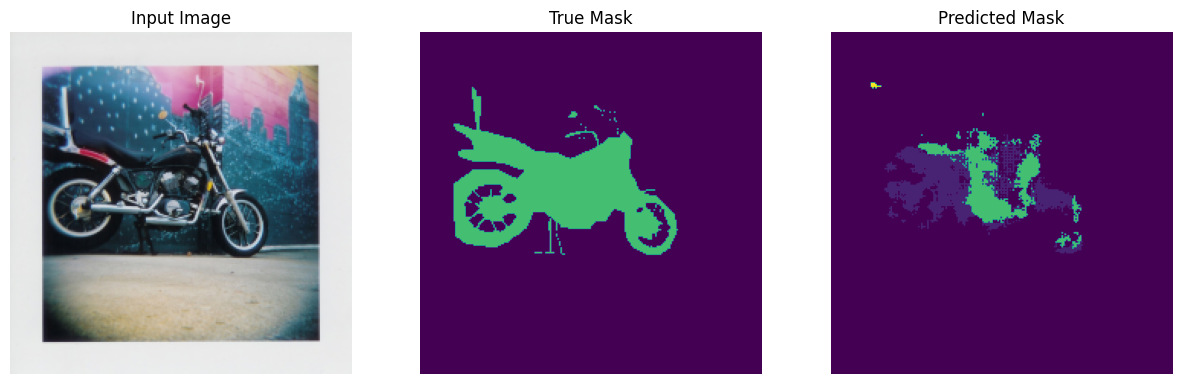

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(1, 224, 224, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(224, 224)


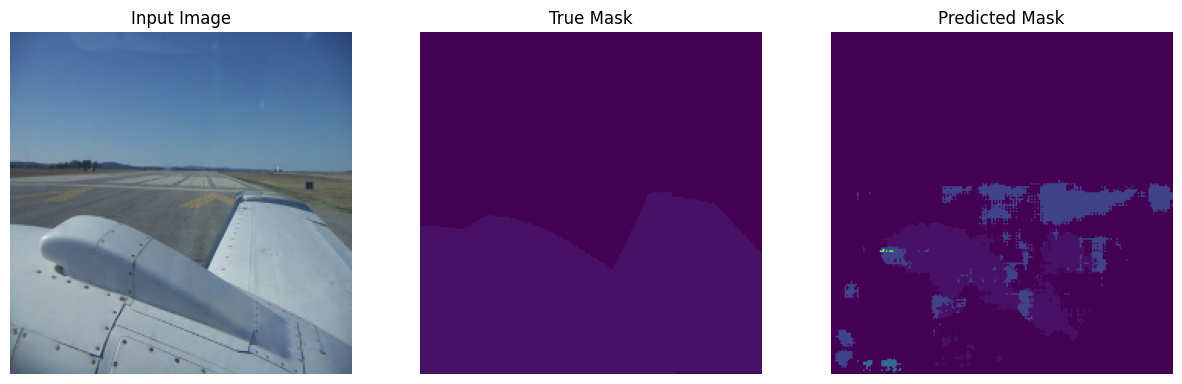

In [25]:
show_predictions(val_set, 3)

In [26]:
X_test = resize_images(test_df["img"],(IMG_HEIGHT,IMG_WIDTH, 3))
res = model.predict(X_test)
masks = np.argmax(res,axis=-1).astype(np.uint8)
test_df["seg"] = [tf.image.resize(masks[i][None,...,None],(img.shape[0],img.shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) for i,img in enumerate(test_df["img"])]

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step


In [27]:
generate_submission(test_df)

,Predicted
Id,
0_classification,1 20
0_segmentation,485860 7 486360 7 486860 9 487358 14 487858 14...
1_classification,1 20
1_segmentation,1757874 2 1762456 3 1762956 3 1763485 3 176398...
2_classification,1 20
...,...
747_segmentation,429584 2 430084 2 430584 2 431084 2 431584 2 4...
748_classification,1 20
748_segmentation,881735 3 881744 3 882235 3 882244 3 882726 3 8...
